In [1]:
## Setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import utilities


Loading vector data
Loading image data
Preprocessing data
Input shape:  (9400, 48, 64, 2)
INFO:tensorflow:Restoring parameters from ./classification_model-210


INFO:tensorflow:Restoring parameters from ./classification_model-210


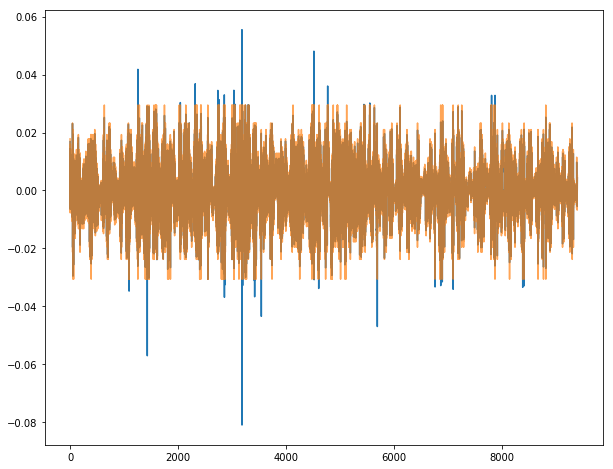

In [29]:
BATCH_SIZE = 64
NUM_CLASSES = 128
TRAIN_RATIO = 0.6

import utilities
# Datafile options:
imu_data,x_data,y_norm = utilities.load_data('flows_lowres_16k.npy')
#imu_data,flows_data,y_norm = utilities.load_data('../gbucket/center_cropped_300x300.npy')
#imu_data,x_data,y_norm = utilities.load_data('../gbucket/center_cropped_192x192.npy')

# Split into training/val data:
N_training = int(TRAIN_RATIO*x_data.shape[0])
N_validation = x_data.shape[0]- N_training

y_data, mean_vals = utilities.discretize_outputs(y_norm[0:N_training], NUM_CLASSES)
y_data, tmp = utilities.discretize_outputs(y_norm, NUM_CLASSES)

x_train = x_data[0:N_training,...]
y_train = y_data[0:N_training]

x_val = x_data[N_training:,...]
y_val = y_data[N_training:]

print('Input shape: ', x_data.shape)

# Plot the discretization with perfect classification:
plt.plot(y_norm)
plt.plot(mean_vals[y_data.astype(np.int32)],alpha=0.7)

from classifiers.squeezenet import SqueezeNet

tf.reset_default_graph() # remove all existing variables in the graph 
sess = get_session() # start a new Session

# Load the model:
model = SqueezeNet(NUM_CLASSES, x_data.shape[3], x_data.shape[1])
# If you want a pretrained model, pass save_path as an argument. 
# Since pretrained weights didn't do well, let's skip them. 
# SAVE_PATH = 'classifiers/squeezenet.ckpt'

# Slow way to initialize variables that is robust to partially loaded models:
uninitialized_vars = []
for var in tf.global_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)
        
init = tf.variables_initializer(uninitialized_vars)
sess.run(init)

saver = tf.train.Saver()
#saver.restore(sess, './checkpoints/good_run')
saver.restore(sess, tf.train.latest_checkpoint('.'))

In [34]:
# Use discretized output with realistic labels:
ground_truth = mean_vals[y_data.astype(np.int32)]

# Compute prediction:
y_pred = np.zeros_like(y_data)
for k in range(0,x_data.shape[0]-(x_data.shape[0]%BATCH_SIZE),BATCH_SIZE):
    imgs = x_data[k:k+BATCH_SIZE,:,:]
    pred = sess.run(model.prediction, feed_dict={model.image: imgs, model.labels: y_norm[k:k+BATCH_SIZE]})
    y_pred[k:k+BATCH_SIZE] = pred
prediction = mean_vals[(y_pred).astype(np.int32)];

ground_truth= np.clip(ground_truth, -100, 0)
prediction = np.clip(prediction, -100, 0)


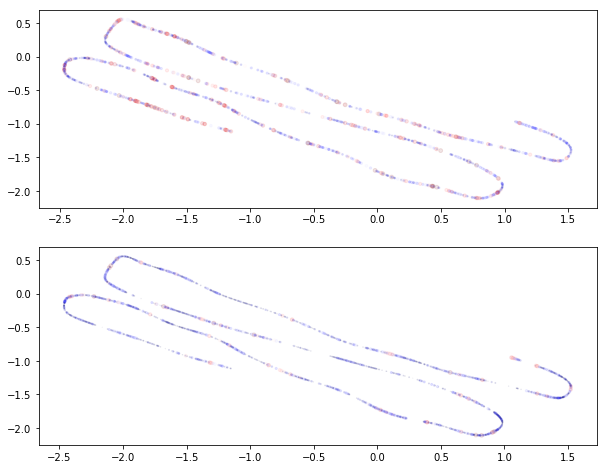

plotting from  0  to  9400
High correlation (near 1) means we are predicting well.
Correlation between error and signal: 0.371275896075


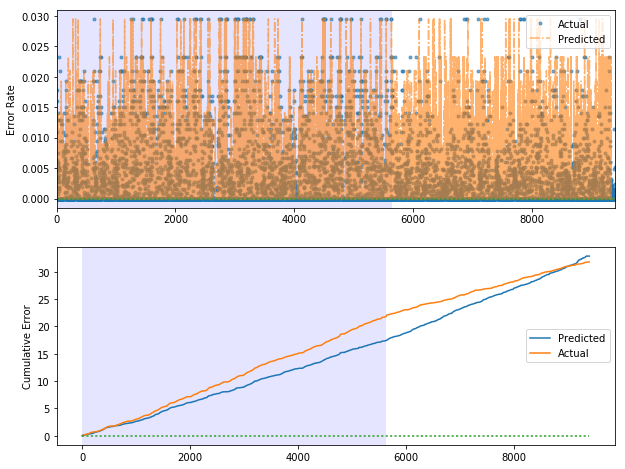

In [33]:
xpos = imu_data[N_training:-BATCH_SIZE,-3]
ypos = imu_data[N_training:-BATCH_SIZE,-2]

# Now generate the figures that Brian wants:
min_val = np.min(mean_vals)
max_val = np.max(mean_vals)
plt.subplot(2,1,1)
plt.scatter(xpos,ypos,c=np.abs(prediction[N_training:-BATCH_SIZE]),s=15*np.abs(prediction[N_training:-BATCH_SIZE])/max_val, cmap='seismic',alpha=0.1)
plt.clim([0, np.log(1+max_val)])
plt.subplot(2,1,2)
plt.scatter(xpos,ypos,c=np.abs(ground_truth[N_training:-BATCH_SIZE]),s=15*np.abs(ground_truth[N_training:-BATCH_SIZE])/max_val,cmap='seismic',alpha=0.1)
plt.clim([0, np.max([-min_val,max_val])])
plt.show()


c = utilities.plot_data(0,y_data.shape[0], prediction, ground_truth, x_train.shape[0])